In [1]:
from autoML import AutoML
from autosklearn.regression import AutoSklearnRegressor
import pandas as pd
import sklearn as sk
import numpy as np

## Loading the data

In [2]:
data = pd.read_csv("datasets/Fish.csv")
print(data.head())
print("Data shape:", data.shape)

  Species  Weight  Length1  Length2  Length3   Height   Width
0   Bream   242.0     23.2     25.4     30.0  11.5200  4.0200
1   Bream   290.0     24.0     26.3     31.2  12.4800  4.3056
2   Bream   340.0     23.9     26.5     31.1  12.3778  4.6961
3   Bream   363.0     26.3     29.0     33.5  12.7300  4.4555
4   Bream   430.0     26.5     29.0     34.0  12.4440  5.1340
Data shape: (159, 7)


## Split into test and training set

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)

train.shape, test.shape

((127, 7), (32, 7))

## Get knowledge over dataset

In [4]:
train.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
89,Perch,135.0,20.0,22.0,23.5,5.8750,3.5250
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
56,Whitefish,270.0,24.1,26.5,29.3,8.1454,4.2485
87,Perch,120.0,20.0,22.0,23.5,5.6400,3.5250
52,Roach,290.0,24.0,26.0,29.2,8.8768,4.4968


The dataset has 7 attributes (incl. the target attribute *weight*). The attributes *Length1*, *Length2*, *Length3*, *Height* and *Width* are numerical. The attribute *Species* is nominal.

In [5]:
train.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,413.328346,26.537795,28.728346,31.576378,9.152379,4.480565
std,368.992498,10.008131,10.745578,11.634974,4.320163,1.724264
min,0.000000,9.300000,9.800000,10.800000,1.728400,1.047600
25%,125.000000,19.200000,21.000000,23.200000,6.191850,3.385650
50%,300.000000,25.400000,27.500000,30.600000,8.323000,4.322500
75%,682.500000,32.600000,35.000000,39.650000,12.437650,5.865300
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


In [6]:
set(train["Species"])

{'Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'}

<AxesSubplot:ylabel='Species'>

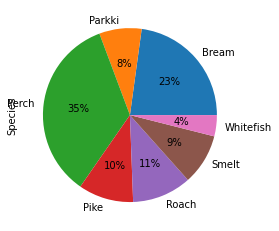

In [7]:
train.groupby("Species").size().plot.pie(ylabel="Species", autopct=lambda val: "{:0.0f}%".format(val))

<AxesSubplot:>

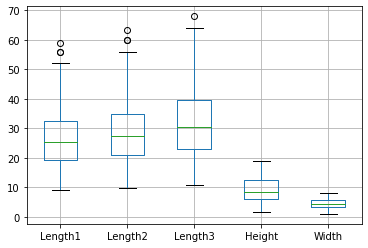

In [8]:
train.drop("Weight", axis=1).boxplot()

## Initialize all regressors

In [9]:
class DummyRegressor():
    def fit(self, X_train, y_train):
        self.range = min(y_train), max(y_train)
    
    def predict(self, X_test):
        return np.random.uniform(self.range[0], self.range[1], [len(X_test)])
    
    def get_params(self, deep=True):
        return {}      

regressors = {
    "dummy": DummyRegressor(),
    "decisionTree": sk.tree.DecisionTreeRegressor(),
    "linearRegression": sk.linear_model.LinearRegression(),
    "randomForestRegressor": sk.ensemble.RandomForestRegressor(),
    "auto-sklearn" : AutoSklearnRegressor(
        time_left_for_this_task = 60,
        per_run_time_limit = 10,
        n_jobs=-1
    ),
    # our regressors
    "autoML": AutoML(fitting_time=60, n_jobs=-1),
}

## Check training performance

In [10]:
from sklearn.metrics import make_scorer

def relative_squared_error(y_pred, y_test):
    avg = np.average(y_test)
    error = y_pred-y_test
    mean_error = -(y_test-avg)
    return np.sum(error**2)/np.sum(mean_error**2)

def correlation_coefficient(y_pred, y_test):
    return np.corrcoef(np.array([y_pred, y_test]))[0][1]

def check_stats(predictor, X, y, name):
    
    scoring = {
        "MSE": make_scorer(sk.metrics.mean_absolute_error),
        "RSE": make_scorer(relative_squared_error),
        "CorrCoef": make_scorer(correlation_coefficient)
    }

    result = sk.model_selection.cross_validate(predictor, X, y, scoring=scoring)

    fit_time = np.mean(result["fit_time"])
    score_time = np.mean(result["score_time"])
    mse = np.mean(result["test_MSE"])
    rse = np.mean(result["test_RSE"])
    corr = np.mean(result["test_CorrCoef"])

    return name, mse, rse, corr, fit_time, score_time

In [11]:
def get_performance(regressors, X, y):
    # check stats of all regressors
    columns = ["Name", "MAE", "RSE", "Corr", "Fit time", "Score time"]
    rows = []
    for regressor_name in regressors:
        stats = check_stats(regressors[regressor_name], X, y, regressor_name)
        rows.append(stats)
    stats = pd.DataFrame(rows, columns=columns)
    return stats

### Preprocessing - Removing "Species"

In [12]:
X_rem = train.drop(["Weight", "Species"], axis=1)
y_rem = train["Weight"]

stats_rem = get_performance(regressors, X_rem, y_rem)
stats_rem

/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  warning

,Name,MAE,RSE,Corr,Fit time,Score time
0,dummy,624.252689,2.665834,-0.084278,0.000574,0.003000
1,decisionTree,59.275200,0.074048,0.968784,0.002131,0.002152
2,linearRegression,99.833350,0.158089,0.935576,0.023024,0.002509
3,randomForestRegressor,49.307940,0.055176,0.977568,0.107127,0.008593
4,auto-sklearn,38.831600,0.039179,0.987255,62.548902,0.130831
5,autoML,43.840397,0.038512,0.982764,60.192268,0.004004


### Preprocessing - One-hot encoding "Species"

In [13]:
train_encoded = pd.get_dummies(train, columns=["Species"])
train_encoded.head()

,Weight,Length1,Length2,Length3,Height,Width,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
89,135.0,20.0,22.0,23.5,5.8750,3.5250,0,0,1,0,0,0,0
1,290.0,24.0,26.3,31.2,12.4800,4.3056,1,0,0,0,0,0,0
56,270.0,24.1,26.5,29.3,8.1454,4.2485,0,0,0,0,0,0,1
87,120.0,20.0,22.0,23.5,5.6400,3.5250,0,0,1,0,0,0,0
52,290.0,24.0,26.0,29.2,8.8768,4.4968,0,0,0,0,1,0,0


In [14]:
X_enc = train_encoded.drop("Weight", axis=1)
y_enc = train_encoded["Weight"]

stats_enc = get_performance(regressors, X_enc, y_enc)
stats_enc

/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  warning

,Name,MAE,RSE,Corr,Fit time,Score time
0,dummy,547.253396,2.341035,-0.057675,0.002096,0.001766
1,decisionTree,57.316892,0.069916,0.970248,0.002820,0.002805
2,linearRegression,70.187825,0.078553,0.966928,0.003378,0.002076
3,randomForestRegressor,49.420546,0.059002,0.976115,0.100577,0.010479
4,auto-sklearn,37.588227,0.037360,0.988233,60.858815,0.101023
5,autoML,42.045139,0.035773,0.986049,60.497224,0.021550


### Preprocessing - One-hot encoding + standardization

In [15]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X_enc)

X_std = pd.DataFrame(x_scaled, columns=X_enc.columns)
y_std = y_enc

X_std.index = y_std.index

stats_std = get_performance(regressors, X_std, y_std)
stats_std

/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  warning

,Name,MAE,RSE,Corr,Fit time,Score time
0,dummy,636.919519,2.663680,-0.130703,0.001001,0.003696
1,decisionTree,60.364800,0.080422,0.966460,0.002846,0.002410
2,linearRegression,70.187825,0.078553,0.966928,0.002366,0.002086
3,randomForestRegressor,46.596364,0.048883,0.979514,0.117138,0.014174
4,auto-sklearn,38.151708,0.037696,0.987442,60.797267,0.134683
5,autoML,42.169549,0.031604,0.986243,60.887548,0.030602


The performance checks show that the preprocessing step of one-hot encode the "Species" column is better than removing the column and has not real benefit over additional standardization.
Therefore one-hot encoding is enough.

## Checking performance on test set

In [16]:
from time import time

def get_test_performance(regressor, X, y):   
    t = time()
    y_pred = regressor.predict(X)
    t = time() - t
    
    mae = sk.metrics.mean_absolute_error(y_pred, y)
    rse = relative_squared_error(y_pred, y)
    corr = correlation_coefficient(y_pred,y)
    
    return mae, rse, corr, t
    

In [17]:
X_test = pd.get_dummies(test.drop("Weight", axis=1), columns=["Species"])
y_test = test["Weight"]

X_train = pd.get_dummies(train.drop("Weight", axis=1), columns=["Species"])
y_train = train["Weight"]

missing_cols = set(X_train.columns) - set(X_test.columns)
for c in missing_cols:
    X_test[c] = 0
    np.int8(X_test[c])
X_test = X_test[X_train.columns]

test_performance = []
for name in regressors:
    regressor = regressors[name]
    train_t = time()
    regressor.fit(X_train, y_train)
    train_t = time() - train_t
    mae, rse, corr, test_t = get_test_performance(regressor, X_test, y_test)
    test_performance.append((name, mae, rse, corr, train_t, test_t))

test_stats = pd.DataFrame(test_performance, columns=["Name", "MAE", "RSE", "CorrCoeff", "TrainTime", "TestTime"])
test_stats

,Name,MAE,RSE,CorrCoeff,TrainTime,TestTime
0,dummy,619.598421,6.424857,0.198924,0.000258,0.000078
1,decisionTree,42.584375,0.058515,0.970482,0.004001,0.001475
2,linearRegression,78.366067,0.149619,0.944377,0.001766,0.001375
3,randomForestRegressor,26.954219,0.020708,0.990149,0.123372,0.011076
4,auto-sklearn,28.404220,0.017153,0.992727,70.989526,0.051666
5,autoML,27.686982,0.013532,0.993604,60.385515,0.001800
